In [233]:
import json
import urllib3
import time
import urllib.request
import pandas as pd
import numpy
from pandas.io.json import json_normalize
%matplotlib inline
import pickle
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
#pip install brewer2mpl

plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['legend.frameon'] = True

#pd.set_option('display.max_rows', 50)
#pd.set_option('display.max_columns', 50)

import seaborn as sns
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set(style='ticks', palette='Set2')
sns.despine()

<Figure size 432x288 with 0 Axes>

In [234]:
def requestData(query):
    return json_normalize(json.load(urllib.request.urlopen(query))["data"]["result"])

def queryBuilder(q1):
    url   = 'http://ec2-34-221-15-134.us-west-2.compute.amazonaws.com:8888/api/v1/query?'
    query = 'query='+q1
    return url+query

#query_range?query=up&start=2015-07-01T20:10:30.781Z&end=2015-07-01T20:11:00.781Z&step=15s
def queryRangeBuilder(query,start,end):
    url   = 'http://ec2-34-221-15-134.us-west-2.compute.amazonaws.com:8888/api/v1/query_range?'
    query = 'query='+ query
    start = 'start='+ start + ".000Z"
    end   = 'end='  + end   + ".000Z"
    steps = 'step=60s' 
    return url+query+"&"+start+"&"+end+"&"+steps


In [235]:
def getCPU(start,end):
    cpuUsage = requestData(queryRangeBuilder('100-(avg%20by%20(instance,mode)%20(irate(node_cpu_seconds_total[1m]))*100)',start,end)).explode('values')
    cpuUsage = cpuUsage[cpuUsage['metric.mode'] =='idle'].drop(['metric.mode'],axis=1)
    cpuUsage['time'] = cpuUsage['values'].apply(lambda x: x[0])
    cpuUsage["host_load_average"] = cpuUsage['values'].apply(lambda x: float(x[1]))
    cpuUsage["metric.instance"] = cpuUsage['metric.instance'].apply(lambda x: x.split(":")[0])
    return cpuUsage.groupby(['time','metric.instance']).sum()

def getNetworkIn(start,end):
    Network = requestData(queryRangeBuilder('irate(node_network_receive_bytes_total[1m])',start,end)).drop(["metric.job"],axis=1).explode('values')
    Network = Network[Network['metric.device'] =='eth0'].drop(['metric.device'],axis=1)
    Network['time'] = Network['values'].apply(lambda x: x[0])
    Network["NetworkIn"] = Network['values'].apply(lambda x: float(x[1])/1000000)
    Network["metric.instance"] = Network['metric.instance'].apply(lambda x: x.split(":")[0])
    return Network.groupby(['time','metric.instance']).sum()

def getNetworkOut(start,end):
    Network = requestData(queryRangeBuilder('irate(node_network_transmit_bytes_total[1m])',start,end)).drop(["metric.job"],axis=1).explode('values')
    Network = Network[Network['metric.device'] =='eth0'].drop(['metric.device'],axis=1)
    Network['time'] = Network['values'].apply(lambda x: x[0])
    Network["NetworkOut"] = Network['values'].apply(lambda x: float(x[1])/1000000)
    Network["metric.instance"] = Network['metric.instance'].apply(lambda x: x.split(":")[0])
    return Network.groupby(['time','metric.instance']).sum()

def getMemory(start,end):
    memory = requestData(queryRangeBuilder('jvm_memory_pool_committed_bytes',start,end)).drop(["metric.job","metric.__name__","metric.component"],axis=1).explode('values')
    #memory = memory[memory['metric.pool'] =='shenandoah'].drop(['metric.pool'],axis=1)
    memory['time'] = memory['values'].apply(lambda x: x[0])
    memory["usedMemory"] = memory['values'].apply(lambda x: float(x[1])/1000000000)
    memory["metric.instance"] = memory['metric.instance'].apply(lambda x: x.split(":")[0])
    return memory.groupby(['time','metric.instance']).sum()

def getMailbox(start,end):
    mailbox = requestData(queryRangeBuilder("akka_group_pending_messages_sum",start,end)).explode('values').drop(['metric.job','metric.system','metric.group'],axis=1)
    mailbox['time'] = mailbox['values'].apply(lambda x: x[0])
    mailbox["mailbox"] = mailbox['values'].apply(lambda x: float(x[1]))
    mailbox["metric.instance"] = mailbox['metric.instance'].apply(lambda x: x.split(":")[0])
    return mailbox.groupby(['time','metric.instance']).sum()

def getMailboxTime(start,end):
    mailbox = requestData(queryRangeBuilder("akka_group_time_in_mailbox_seconds_sum",start,end)).explode('values').drop(['metric.job','metric.system','metric.group'],axis=1)
    mailbox['time'] = mailbox['values'].apply(lambda x: x[0])
    mailbox["mailboxTime"] = mailbox['values'].apply(lambda x: float(x[1]))
    mailbox["metric.instance"] = mailbox['metric.instance'].apply(lambda x: x.split(":")[0])
    return mailbox.groupby(['time','metric.instance']).sum()

def getGC(start,end):
    gc = requestData(queryRangeBuilder("jvm_gc_seconds_sum",start,end)).drop(["metric.job","metric.__name__","metric.component","metric.generation"],axis=1).explode('values')
    gc["metric.instance"] = gc['metric.instance'].apply(lambda x: x.split(":")[0])
    gc['time'] = gc['values'].apply(lambda x: x[0])
    gc1=gc[gc['metric.collector'] =='shenandoah-cycles'].drop(["metric.collector"],axis=1)
    gc2=gc[gc['metric.collector'] =='shenandoah-pauses'].drop(["metric.collector"],axis=1)
    gc1["cycles"] = gc1['values'].apply(lambda x: float(x[1]))
    gc2["pauses"] = gc2['values'].apply(lambda x: float(x[1]))
        
    return gc1.groupby(['time','metric.instance']).sum().join(gc2.groupby(['time','metric.instance']).sum())

def pmdataParser(start,end,field):
    data = requestData(queryRangeBuilder(field,start,end)).drop(["metric.job"],axis=1).explode('values')
    data['time'] = data['values'].apply(lambda x: x[0])
    data[field] = data['values'].apply(lambda x: int(x[1]))
    data["metric.instance"] = data['metric.instance'].apply(lambda x: x.split(":")[0])
    return data.groupby(['time','metric.instance','metric.actor','metric.ID']).sum()

def pmdataParser2(start,end,name,field):
    data = requestData(queryRangeBuilder(field,start,end)).explode('values')
    data['time'] = data['values'].apply(lambda x: x[0])
    data[name] = data['values'].apply(lambda x: float(x[1]))
    data["metric.instance"] = data['metric.instance'].apply(lambda x: x.split(":")[0])
    return data.groupby(['time','metric.instance','metric.actor','metric.ID']).sum()


def spoutdataParser(start,end,field):
    data = requestData(queryRangeBuilder(field,start,end)).drop(["metric.job"],axis=1).explode('values')
    data['time'] = data['values'].apply(lambda x: x[0])
    data[field] = data['values'].apply(lambda x: int(x[1]))
    data["metric.instance"] = data['metric.instance'].apply(lambda x: x.split(":")[0])
    return data.groupby(['time','metric.instance','metric.actor']).sum()

def routerdataParser(start,end,field):
    data = requestData(queryRangeBuilder(field,start,end)).drop(["metric.job","metric.__name__"],axis=1).explode('values')
    data['time'] = data['values'].apply(lambda x: x[0])
    data[field] = data['values'].apply(lambda x: int(x[1]))
    data["metric.instance"] = data['metric.instance'].apply(lambda x: x.split(":")[0])
    return data.groupby(['time','metric.instance','metric.Router']).sum()


def PartitionManager(start,end,cpu,memory,networkIn,networkOut,mailbox,mailboxtime,gc):
    updates = pmdataParser(start,end,"Raphtory_Router_Updates_total")
    intra = pmdataParser(start,end,"Raphtory_Intra_Worker_Updates_total")
    inter = pmdataParser(start,end,"Raphtory_Inter_Worker_Updates_total")
    vertex = pmdataParser(start,end,"Raphtory_Vertex_Count_total") 
    ledge = pmdataParser(start,end,"Raphtory_Local_Edge_Count_total") 
    medge = pmdataParser(start,end,"Raphtory_Master_Split_Edge_Count_total") 
    cedge = pmdataParser(start,end,"Raphtory_Copy_Split_Edge_Count_total")
    eTime = pmdataParser(start,end,"Raphtory_Earliest_Time") 
    lTime = pmdataParser(start,end,"Raphtory_Latest_Time")
    sTime = pmdataParser(start,end,"Raphtory_Safe_Time") 
    synch = pmdataParser(start,end,"Raphtory_Synchronised_Updates_total")
    arrivalTime = pmdataParser2(start,end,"Update_Arrival_Time","avg((Raphtory_Wall_Clock_sum)/(Raphtory_Wall_Clock_count)/1000)%20by%20(actor,ID,instance)")

    pm = updates.join(intra).join(inter).join(vertex).join(ledge).join(medge).join(cedge).join(eTime).join(lTime).join(sTime).join(synch).join(arrivalTime).join(cpu).join(memory).join(networkIn).join(networkOut).join(mailbox).join(mailboxtime).join(gc).reset_index()
    return pm
    
def Router(start,end,cpu,memory,networkIn,networkOut,mailbox,mailboxtime,gc):
    updates = routerdataParser(start,end,"Raphtory_Router_Output_total")
    return updates.join(cpu).join(memory).join(networkIn).join(networkOut).join(mailbox).join(mailboxtime).join(gc).reset_index()

def Spout(start,end,cpu,memory,networkIn,networkOut,mailbox,mailboxtime,gc):
    updates = spoutdataParser(start,end,"Raphtory_Spout_Tuples_total")
    updates = updates.join(cpu).join(memory).join(networkIn).join(networkOut).join(mailbox).join(mailboxtime).join(gc).reset_index()
    return updates[updates['metric.instance'].str.contains(set(list(updates['metric.instance'])).pop())]


def diff(data):
    return list(numpy.diff(list(map((lambda x: x/60),list(data)))))

def million(data):
    return list(map((lambda x: float(x)/1000000),data))


#Raphtory_Safe_Time

def exportRaphtoryRun(start,end,runName):
    os.makedirs("Exported_Runs/"+runName+"/", exist_ok=True)
    cpu = getCPU(start,end)
    memory = getMemory(start,end)
    networkIn = getNetworkIn(start,end)
    networkOut = getNetworkOut(start,end)
    mailbox= getMailbox(start,end)
    mailboxtime = getMailboxTime(start,end)
    gc = getGC(start,end)
    pm=PartitionManager(start,end,cpu,memory,networkIn,networkOut,mailbox,mailboxtime,gc)
    router=Router(start,end,cpu,memory,networkIn,networkOut,mailbox,mailboxtime,gc)
    spout=Spout(start,end,cpu,memory,networkIn,networkOut,mailbox,mailboxtime,gc)
    pm.to_csv("Exported_Runs/"+runName+"/writer.csv")
    router.to_csv("Exported_Runs/"+runName+"/router.csv")
    spout.to_csv("Exported_Runs/"+runName+"/spout.csv")
    f = open("Exported_Runs/"+runName+"/meta.txt", "a")
    f.write("StartTime:"+start+"\n")
    f.write("EndTime:"+end+"\n")
    f.close()


def readRaphtoryRun(runName):
    pm = pd.read_csv("Exported_Runs/"+runName+"/writer.csv").drop("Unnamed: 0",axis=1)
    router = pd.read_csv("Exported_Runs/"+runName+"/router.csv").drop("Unnamed: 0",axis=1)
    spout = pd.read_csv("Exported_Runs/"+runName+"/spout.csv").drop("Unnamed: 0",axis=1)
    return [pm,router,spout]


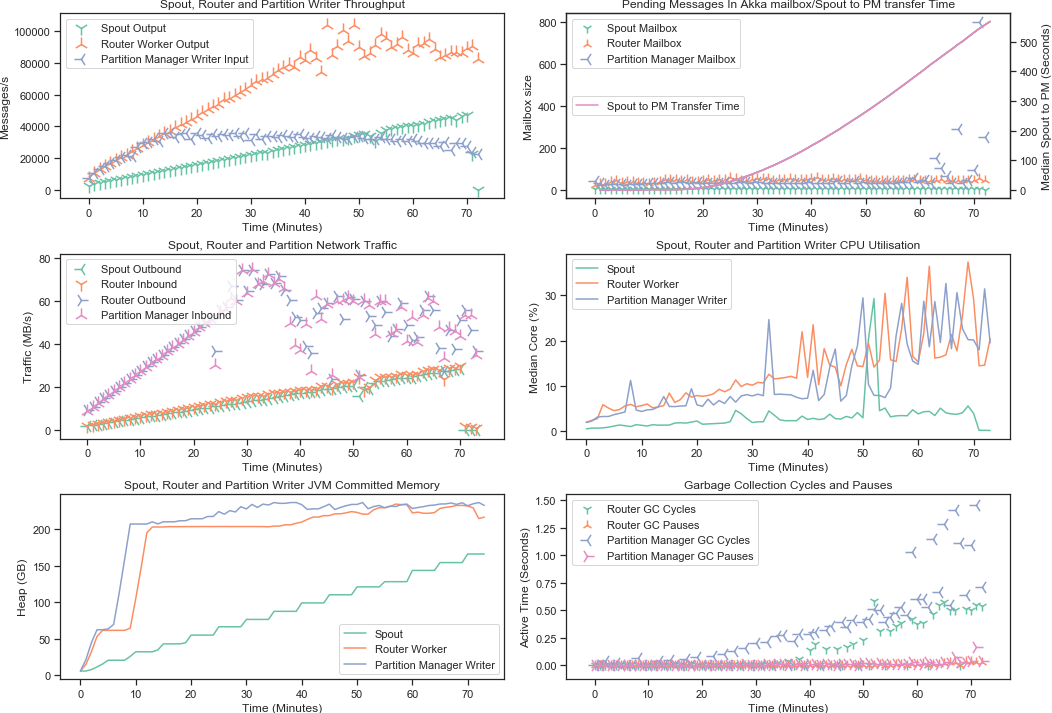

In [217]:
def explorePlot(pm,router,spout,name):

    
    pmMin         =pm.groupby('time').min().reset_index()
    pmMax         =pm.groupby('time').max().reset_index()
    pmMean        =pm.groupby(['time','metric.actor']).mean().reset_index().groupby('time').mean().reset_index()
    pmMedian      =pm.groupby(['time','metric.actor']).median().reset_index().groupby('time').median().reset_index()
    pmSum         =pm.groupby('time').sum()
    
    #routerMin     =router.groupby(['time','metric.Router']).min().reset_index()
    #routerMean    =router.groupby(['time','metric.Router']).mean().reset_index()
    routerMedian  =router.groupby(['time','metric.Router']).median().reset_index().groupby('time').median().reset_index()
    routerSum     =router.groupby('time').sum()

    #spoutMin      =spout.groupby(['time','metric.actor']).min().reset_index()
    #spoutMean     =spout.groupby(['time','metric.actor']).mean().reset_index().groupby('time').mean().reset_index()
    spoutMedian   =spout.groupby(['time','metric.actor']).median().reset_index().groupby('time').median().reset_index()
    spoutSum      =spout.groupby('time').sum()
    
    
    pmCPU         = list(pmMedian['host_load_average'])
    pmMem         = list(pmMedian['usedMemory'])
    pmNI          = list(pmMedian['NetworkIn'])
    pmNO          = list(pmMedian['NetworkOut'])
    pmMailbox     = diff(pmMedian['mailbox'])
    pmMailboxTime = diff(pmMedian['mailboxTime'])
    pmCycles      = diff(pmMedian['cycles'])
    pmPauses      = diff(pmMedian['pauses'])
    pmUpdates     = diff(pmSum['Raphtory_Router_Updates_total'])
    pmIntra       = diff(pmSum['Raphtory_Intra_Worker_Updates_total'])
    pmInter       = diff(pmSum['Raphtory_Inter_Worker_Updates_total'])
    pmVertex      = list(pmSum['Raphtory_Vertex_Count_total'])
    pmLEdge       = list(pmSum['Raphtory_Local_Edge_Count_total'])
    pmMEdge       = list(pmSum['Raphtory_Master_Split_Edge_Count_total'])
    pmCEdge       = list(pmSum['Raphtory_Copy_Split_Edge_Count_total'])
    pmTEdge       = [sum(x) for x in zip(pmLEdge, pmMEdge)]
    pmLTime       = list(pmMax['Raphtory_Latest_Time'])
    pmSTime       = list(pmMin['Raphtory_Safe_Time'])
    pmDiffTime    = numpy.subtract(pmLTime,pmSTime)
    pmSyncUpdates = list(pmSum['Raphtory_Synchronised_Updates_total'])
    pmUnSync      = numpy.subtract(pmSyncUpdates,list(pmSum['Raphtory_Router_Updates_total']))  
    pmArrivalTime = list(pmMedian['Update_Arrival_Time'])
    
    
    rCPU          = list(routerMedian['host_load_average'])
    rMem          = list(routerMedian['usedMemory'])
    rNI           = list(routerSum['NetworkIn'])
    rNO           = list(routerSum['NetworkOut'])
    rMailbox      = diff(routerMedian['mailbox'])
    rMailboxTime  = diff(routerMedian['mailboxTime'])
    rCycles       = diff(routerMedian['cycles'])
    rPauses       = diff(routerMedian['pauses'])
    rUpdates      = diff(routerSum['Raphtory_Router_Output_total'])
   

    sCPU          = list(spoutMedian['host_load_average'])
    sMem          = list(spoutMedian['usedMemory'])
    sNI           = list(spoutMedian['NetworkIn'])
    sNO           = list(spoutMedian['NetworkOut'])
    sMailbox      = diff(spoutMedian['mailbox'])
    sMailboxTime  = diff(spoutMedian['mailboxTime'])
    sCyles        = diff(spoutMedian['cycles'])
    sPauses       = diff(spoutMedian['pauses'])
    sUpdates      = diff(spoutSum['Raphtory_Spout_Tuples_total'])
    sTotalUpdates = list(spoutSum['Raphtory_Spout_Tuples_total'])
    
    
    fig           = plt.figure(constrained_layout=True,figsize=[14.7, 10])
    spec          = gridspec.GridSpec(ncols=2, nrows=9, figure=fig)
    #spec.update(wspace=0.01, hspace=0.05) # set the spacing between axes. 

    ax1 = fig.add_subplot(spec[0:3, 0])
    ax3 = fig.add_subplot(spec[3:6, 0])
   # ax4 = fig.add_subplot(spec[6:9, 0])
    ax5 = fig.add_subplot(spec[6:9, 0])
   # ax2 = fig.add_subplot(spec[0:3, 1])
    ax6 = fig.add_subplot(spec[0:3, 1])
    ax7 = fig.add_subplot(spec[3:6, 1])
    ax8 = fig.add_subplot(spec[6:9, 1])

    
    #UPDATE THROUGHPUT
    plt.setp([ax1], title='Spout, Router and Partition Writer Throughput')
    plt.setp([ax1], xlabel='Time (Minutes)')
    plt.setp([ax1], ylabel='Messages/s')
    
    ax1.scatter(range(0,len(sUpdates)),sUpdates,label="Spout Output",marker="1",s=200)
    ax1.scatter(range(0,len(rUpdates)),rUpdates,label="Router Worker Output",marker="2",s=200)
    ax1.scatter(range(0,len(pmUpdates)),pmUpdates,label="Partition Manager Writer Input",marker="3",s=200)
    #ax1.scatter(range(0,len(pmIntra)),pmIntra,label="Partition Manager Intra Writer Synchronisation",marker="4",s=200)
    #ax1.plot(range(0,len(pmInter)),pmInter,label="Partition Manager Inter Writer Synchronisation")
    ax1.legend(loc="best")
    
    
    #GRAPH SIZE
#     plt.setp([ax2], title='Graph Size')
#     plt.setp([ax2], xlabel='Time (Minutes)')
#     plt.setp([ax2], ylabel='Total (Millions)')
   
#     ax2.scatter(range(0,len(pmVertex)),million(pmVertex),label="Vetices",marker="1",s=100)
#     ax2.scatter(range(0,len(pmTEdge)),million(pmTEdge),label="Edges",marker="2",s=100)
#     ax2.scatter(range(0,len(sTotalUpdates)),million(sTotalUpdates),label="Transactions (History)",marker="3",s=100)
#     ax2.annotate(round(million(pmVertex)[len(pmVertex)-1], 1), (len(pmVertex)-1, million(pmVertex)[len(pmVertex)-1]))
#     ax2.annotate(round(million(pmTEdge)[len(pmTEdge)-1], 1), (len(pmTEdge)-1, million(pmTEdge)[len(pmTEdge)-1]))
#     ax2.annotate(round(million(sTotalUpdates)[len(sTotalUpdates)-1], 1), (len(sTotalUpdates)-1, million(sTotalUpdates)[len(sTotalUpdates)-1]))
    
#     ax2.annotate(round(million(pmVertex)[int(len(pmVertex)/2)], 1), (int(len(pmVertex)/2), million(pmVertex)[int(len(pmVertex)/2)]))
#     ax2.annotate(round(million(pmTEdge)[int(len(pmTEdge)/2)], 1), (len(pmTEdge)/2, million(pmTEdge)[int(len(pmTEdge)/2)]))
#     ax2.annotate(round(million(sTotalUpdates)[int(len(sTotalUpdates)/2)], 1), (len(sTotalUpdates)/2, million(sTotalUpdates)[int(len(sTotalUpdates)/2)]))

# #     for i in range(0,len(pmVertex)-1):
# #         if i%10 ==0:
# #             ax2.annotate(round(million(pmVertex)[i], 1), (i, million(pmVertex)[i]))
# #             ax2.annotate(round(million(pmTEdge)[i], 1), (i, million(pmTEdge)[i]))
# #             ax2.annotate(round(million(sTotalUpdates)[i], 1), (i, million(sTotalUpdates)[i]))
#     ax2.legend(loc="best")
    
#     #TRAFFIC
    plt.setp([ax3], title='Spout, Router and Partition Network Traffic')
    plt.setp([ax3], xlabel='Time (Minutes)')
    plt.setp([ax3], ylabel='Traffic (MB/s)')
    
    #ax3.plot(range(0,len(sNI)),sNI,label="Spout Inbound")
    #ax3.plot(range(0,len(pmNO)),pmNO,label="Partition Manager Outbound")
    ax3.scatter(range(0,len(sNO)),sNO,label="Spout Outbound",marker="3",s=200)
    ax3.scatter(range(0,len(rNI)),rNI,label="Router Inbound",marker="1",s=200)
    ax3.scatter(range(0,len(rNO)),rNO,label="Router Outbound",marker="4",s=200)
    ax3.scatter(range(0,len(pmNI)),pmNI,label="Partition Manager Inbound",marker="2",s=200)
    ax3.legend(loc="best")
    
    
    
    #UPDATE TIME
#     plt.setp([ax4], title='SafeTime')
#     plt.setp([ax4], xlabel='Time (Minutes)')
    
#     #plt.setp([ax4], yscale='log')
#     ax4b = ax4.twinx()
    
#     plt.setp([ax4], ylabel='Unsynchronised Messages')
#     plt.setp([ax4b], ylabel='Ethereum Blocks')

#     ax4b.plot(range(0,len(pmDiffTime)),pmDiffTime)#marker="3",s=200)
#     ax4b.plot(range(0,len(pmDiffTime)),pmDiffTime,label="Unsynchronised Blocks")#,marker="3",s=200)
    
#     ax4.plot(range(0,len(pmUnSync)),pmUnSync,label="Unsynchronised Messages")#,marker="4",s=200)
#     ax4.legend(loc="best")
    
#     ax4b.legend(loc="best")
#     #ax4.set(yscale="log")
    #ax4b.set(yscale="log")
    
    
    
    #MAILBOX
    plt.setp([ax6], title='Pending Messages In Akka mailbox/Spout to PM transfer Time')
    plt.setp([ax6], xlabel='Time (Minutes)')
    plt.setp([ax6], ylabel='Mailbox size')

    ax6.scatter(range(0,len(sMailbox)),sMailbox,label="Spout Mailbox",marker="1",s=100)
    ax6.scatter(range(0,len(rMailbox)),rMailbox,label="Router Mailbox",marker="2",s=100)
    ax6.scatter(range(0,len(pmMailbox)),pmMailbox,label="Partition Manager Mailbox",marker="3",s=200)
    
    ax6b = ax6.twinx()
    plt.setp([ax6b], ylabel='Median Spout to PM (Seconds)') 

    ax6b.plot(range(0,len(pmArrivalTime)),pmArrivalTime)#,marker="4",s=100)
    ax6b.plot(range(0,len(pmArrivalTime)),pmArrivalTime)#,marker="4",s=100)
    ax6b.plot(range(0,len(pmArrivalTime)),pmArrivalTime)#,marker="4",s=100)
    ax6b.plot(range(0,len(pmArrivalTime)),pmArrivalTime,label="Spout to PM Transfer Time")#,marker="4",s=200)
    
    ax6.legend(loc="upper left")    
    ax6b.legend(loc="center left")
    
    
    
    #MEMORY UTILISATION
    plt.setp([ax5], title='Spout, Router and Partition Writer JVM Committed Memory')
    plt.setp([ax5], xlabel='Time (Minutes)')
    plt.setp([ax5], ylabel='Heap (GB)')


    ax5.plot(range(0,len(sMem)),sMem,label="Spout")
    ax5.plot(range(0,len(rMem)),rMem,label="Router Worker")
    ax5.plot(range(0,len(pmMem)),pmMem,label="Partition Manager Writer")
    ax5.legend(loc="best")
    
    
    #CPU UTILISATION
    plt.setp([ax7], title='Spout, Router and Partition Writer CPU Utilisation')
    plt.setp([ax7], xlabel='Time (Minutes)')
    plt.setp([ax7], ylabel='Median Core (%)')

    ax7.plot(range(0,len(sCPU)),sCPU,label="Spout")#,marker="1",s=200)
    ax7.plot(range(0,len(rCPU)),rCPU,label="Router Worker")#,marker="2",s=200)
    ax7.plot(range(0,len(pmCPU)),pmCPU,label="Partition Manager Writer")#,marker="3",s=200)
    ax7.legend(loc="best")
    
    
    #GARBAGE COLLECTION
    plt.setp([ax8], title='Garbage Collection Cycles and Pauses')
    plt.setp([ax8], xlabel='Time (Minutes)')
    plt.setp([ax8], ylabel='Active Time (Seconds)')

    #ax8.plot(range(0,len(rCycles)),rCycles,label="Router GC Cycles")
    #ax8.plot(range(0,len(rPauses)),rPauses,label="Router GC Pauses")
    #ax8.plot(range(0,len(pmCycles)),pmCycles,label="Partition Manager GC Cycles")
    #ax8.plot(range(0,len(pmPauses)),pmPauses,label="Partition Manager GC Pauses")
    ax8.scatter(range(0,len(rCycles)),rCycles,label="Router GC Cycles",marker="1",s=100)
    ax8.scatter(range(0,len(rPauses)),rPauses,label="Router GC Pauses",marker="2",s=100)
    ax8.scatter(range(0,len(pmCycles)),pmCycles,label="Partition Manager GC Cycles",marker="3",s=200)
    ax8.scatter(range(0,len(pmPauses)),pmPauses,label="Partition Manager GC Pauses",marker="4",s=200)
    ax8.legend(loc="best")
    plt.savefig(name+'.pdf',bbox_inches='tight')
    plt.show()
 
   
data=readRaphtoryRun("InitialRun1Router")
explorePlot(data[0],data[1],data[2],"InitialRun1RouterFig")
#data[0]

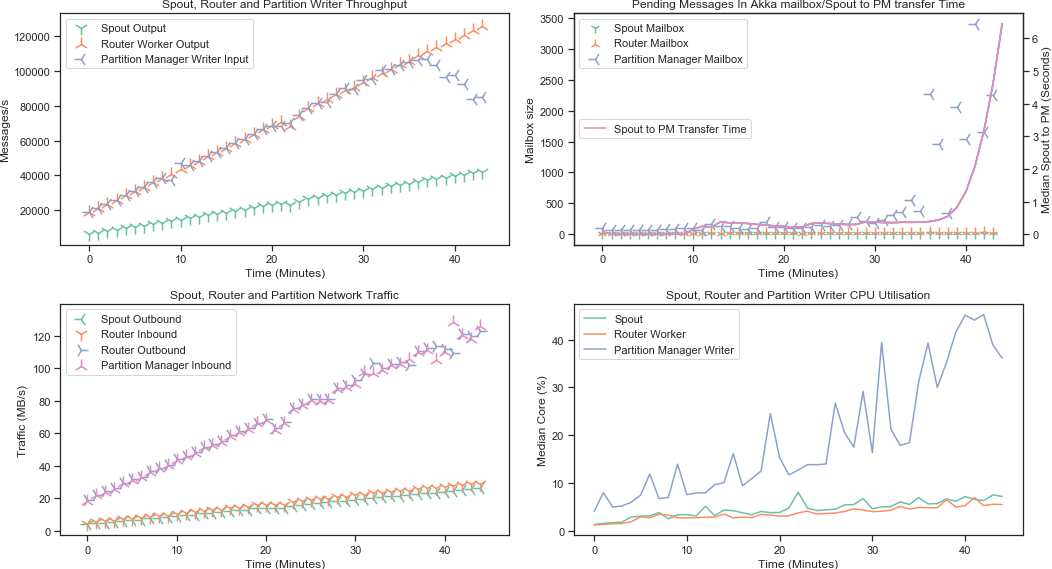

In [232]:
def explorePlot(pm,router,spout,name):
    pmMin         =pm.groupby('time').min().reset_index()
    pmMax         =pm.groupby('time').max().reset_index()
    pmMean        =pm.groupby(['time','metric.actor']).mean().reset_index().groupby('time').mean().reset_index()
    pmMedian      =pm.groupby(['time','metric.actor']).median().reset_index().groupby('time').median().reset_index()
    pmSum         =pm.groupby('time').sum()
    
    #routerMin     =router.groupby(['time','metric.Router']).min().reset_index()
    #routerMean    =router.groupby(['time','metric.Router']).mean().reset_index()
    routerMedian  =router.groupby(['time','metric.Router']).median().reset_index().groupby('time').median().reset_index()
    routerSum     =router.groupby('time').sum()

    #spoutMin      =spout.groupby(['time','metric.actor']).min().reset_index()
    #spoutMean     =spout.groupby(['time','metric.actor']).mean().reset_index().groupby('time').mean().reset_index()
    spoutMedian   =spout.groupby(['time','metric.actor']).median().reset_index().groupby('time').median().reset_index()
    spoutSum      =spout.groupby('time').sum()
    
    
    pmCPU         = list(pmMedian['host_load_average'])
    pmMem         = list(pmMedian['usedMemory'])
    pmNI          = list(pmMedian['NetworkIn'])
    pmNO          = list(pmMedian['NetworkOut'])
    pmMailbox     = diff(pmMedian['mailbox'])
    pmMailboxTime = diff(pmMedian['mailboxTime'])
    pmCycles      = diff(pmMedian['cycles'])
    pmPauses      = diff(pmMedian['pauses'])
    pmUpdates     = diff(pmSum['Raphtory_Router_Updates_total'])
    pmIntra       = diff(pmSum['Raphtory_Intra_Worker_Updates_total'])
    pmInter       = diff(pmSum['Raphtory_Inter_Worker_Updates_total'])
    pmVertex      = list(pmSum['Raphtory_Vertex_Count_total'])
    pmLEdge       = list(pmSum['Raphtory_Local_Edge_Count_total'])
    pmMEdge       = list(pmSum['Raphtory_Master_Split_Edge_Count_total'])
    pmCEdge       = list(pmSum['Raphtory_Copy_Split_Edge_Count_total'])
    pmTEdge       = [sum(x) for x in zip(pmLEdge, pmMEdge)]
    pmLTime       = list(pmMax['Raphtory_Latest_Time'])
    pmSTime       = list(pmMin['Raphtory_Safe_Time'])
    pmDiffTime    = numpy.subtract(pmLTime,pmSTime)
    pmSyncUpdates = list(pmSum['Raphtory_Synchronised_Updates_total'])
    pmUnSync      = numpy.subtract(pmSyncUpdates,list(pmSum['Raphtory_Router_Updates_total']))  
    pmArrivalTime = list(pmMedian['Update_Arrival_Time'])
    
    
    rCPU          = list(routerMedian['host_load_average'])
    rMem          = list(routerMedian['usedMemory'])
    rNI           = list(routerSum['NetworkIn'])
    rNO           = list(routerSum['NetworkOut'])
    rMailbox      = diff(routerMedian['mailbox'])
    rMailboxTime  = diff(routerMedian['mailboxTime'])
    rCycles       = diff(routerMedian['cycles'])
    rPauses       = diff(routerMedian['pauses'])
    rUpdates      = diff(routerSum['Raphtory_Router_Output_total'])
   

    sCPU          = list(spoutMedian['host_load_average'])
    sMem          = list(spoutMedian['usedMemory'])
    sNI           = list(spoutMedian['NetworkIn'])
    sNO           = list(spoutMedian['NetworkOut'])
    sMailbox      = diff(spoutMedian['mailbox'])
    sMailboxTime  = diff(spoutMedian['mailboxTime'])
    sCyles        = diff(spoutMedian['cycles'])
    sPauses       = diff(spoutMedian['pauses'])
    sUpdates      = diff(spoutSum['Raphtory_Spout_Tuples_total'])
    sTotalUpdates = list(spoutSum['Raphtory_Spout_Tuples_total'])
    
    
    fig           = plt.figure(constrained_layout=True,figsize=[14.7, 8])
    spec          = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
    #spec.update(wspace=0.01, hspace=0.05) # set the spacing between axes. 

    ax1 = fig.add_subplot(spec[0, 0])
    ax3 = fig.add_subplot(spec[1, 0])
   # ax4 = fig.add_subplot(spec[6:9, 0])
    ax6 = fig.add_subplot(spec[0, 1])
   # ax2 = fig.add_subplot(spec[0:3, 1])
    #ax5 = fig.add_subplot(spec[0:3, 1])
    ax7 = fig.add_subplot(spec[1, 1])
    #ax8 = fig.add_subplot(spec[6:9, 1])

    
    #UPDATE THROUGHPUT
    plt.setp([ax1], title='Spout, Router and Partition Writer Throughput')
    plt.setp([ax1], xlabel='Time (Minutes)')
    plt.setp([ax1], ylabel='Messages/s')
    
    ax1.scatter(range(0,len(sUpdates)),sUpdates,label="Spout Output",marker="1",s=200)
    ax1.scatter(range(0,len(rUpdates)),rUpdates,label="Router Worker Output",marker="2",s=200)
    ax1.scatter(range(0,len(pmUpdates)),pmUpdates,label="Partition Manager Writer Input",marker="3",s=200)
    #ax1.scatter(range(0,len(pmIntra)),pmIntra,label="Partition Manager Intra Writer Synchronisation",marker="4",s=200)
    #ax1.plot(range(0,len(pmInter)),pmInter,label="Partition Manager Inter Writer Synchronisation")
    ax1.legend(loc="best")
    
#     #TRAFFIC
    plt.setp([ax3], title='Spout, Router and Partition Network Traffic')
    plt.setp([ax3], xlabel='Time (Minutes)')
    plt.setp([ax3], ylabel='Traffic (MB/s)')
    
    #ax3.plot(range(0,len(sNI)),sNI,label="Spout Inbound")
    #ax3.plot(range(0,len(pmNO)),pmNO,label="Partition Manager Outbound")
    ax3.scatter(range(0,len(sNO)),sNO,label="Spout Outbound",marker="3",s=200)
    ax3.scatter(range(0,len(rNI)),rNI,label="Router Inbound",marker="1",s=200)
    ax3.scatter(range(0,len(rNO)),rNO,label="Router Outbound",marker="4",s=200)
    ax3.scatter(range(0,len(pmNI)),pmNI,label="Partition Manager Inbound",marker="2",s=200)
    ax3.legend(loc="best")
    
    #MAILBOX
    plt.setp([ax6], title='Pending Messages In Akka mailbox/Spout to PM transfer Time')
    plt.setp([ax6], xlabel='Time (Minutes)')
    plt.setp([ax6], ylabel='Mailbox size')

    ax6.scatter(range(0,len(sMailbox)),sMailbox,label="Spout Mailbox",marker="1",s=100)
    ax6.scatter(range(0,len(rMailbox)),rMailbox,label="Router Mailbox",marker="2",s=100)
    ax6.scatter(range(0,len(pmMailbox)),pmMailbox,label="Partition Manager Mailbox",marker="3",s=200)
    
    ax6b = ax6.twinx()
    plt.setp([ax6b], ylabel='Median Spout to PM (Seconds)') 

    ax6b.plot(range(0,len(pmArrivalTime)),pmArrivalTime)#,marker="4",s=100)
    ax6b.plot(range(0,len(pmArrivalTime)),pmArrivalTime)#,marker="4",s=100)
    ax6b.plot(range(0,len(pmArrivalTime)),pmArrivalTime)#,marker="4",s=100)
    ax6b.plot(range(0,len(pmArrivalTime)),pmArrivalTime,label="Spout to PM Transfer Time")#,marker="4",s=200)
    
    ax6.legend(loc="upper left")    
    ax6b.legend(loc="center left")
    
    
    #CPU UTILISATION
    plt.setp([ax7], title='Spout, Router and Partition Writer CPU Utilisation')
    plt.setp([ax7], xlabel='Time (Minutes)')
    plt.setp([ax7], ylabel='Median Core (%)')

    ax7.plot(range(0,len(sCPU)),sCPU,label="Spout")#,marker="1",s=200)
    ax7.plot(range(0,len(rCPU)),rCPU,label="Router Worker")#,marker="2",s=200)
    ax7.plot(range(0,len(pmCPU)),pmCPU,label="Partition Manager Writer")#,marker="3",s=200)
    ax7.legend(loc="best")
    plt.savefig(name+'.pdf',bbox_inches='tight')
    plt.show()

 

data=readRaphtoryRun("InitialRun4Router")
explorePlot(data[0],data[1],data[2],"InitialRun4Router")

<Figure size 432x288 with 0 Axes>

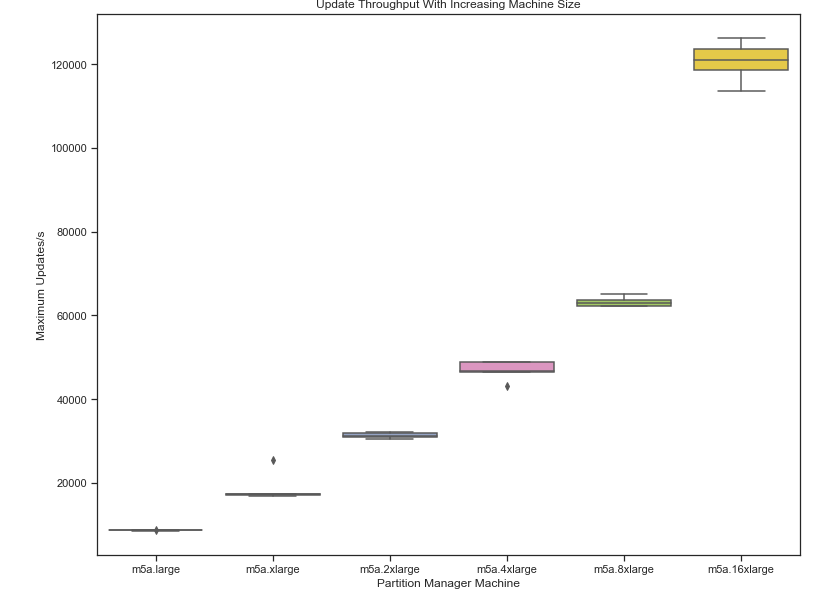

In [231]:
plt.tight_layout()
fig = plt.figure(constrained_layout=True,figsize=[14.7, 10])
spec= gridspec.GridSpec(ncols=3, nrows=1, figure=fig,width_ratios=[0.1,2.8,0.1])


ax1 = fig.add_subplot(spec[0, 1])
plt.setp([ax1], title='Update Throughput With Increasing Machine Size')

def getMax(pm):
    pm = pm[0].groupby('time').sum()
    return max(list(numpy.diff(list(map((lambda x: int(x)/60),list(pm['Raphtory_Router_Updates_total']))))))

def buildList(label,pm1,pm2,pm3,pm4,pm5):
    return [[label,'Writer Input',getMax(pm1)],[label,'Writer Input',getMax(pm2)],
     [label,'Writer Input',getMax(pm3)],[label,'Writer Input',getMax(pm4)],
     [label,'Writer Input',getMax(pm5)]]

pm2=buildList('m5a.large',readRaphtoryRun("ScaleUp_m5a.large_1"),readRaphtoryRun("ScaleUp_m5a.large_2"),readRaphtoryRun("ScaleUp_m5a.large_3"),readRaphtoryRun("ScaleUp_m5a.large_4"),readRaphtoryRun("ScaleUp_m5a.large_5"))
pm4=buildList('m5a.xlarge',readRaphtoryRun("ScaleUp_m5a.xlarge_1"),readRaphtoryRun("ScaleUp_m5a.xlarge_2"),readRaphtoryRun("ScaleUp_m5a.xlarge_3"),readRaphtoryRun("ScaleUp_m5a.xlarge_4"),readRaphtoryRun("ScaleUp_m5a.xlarge_5"))
pm8=buildList('m5a.2xlarge',readRaphtoryRun("ScaleUp_m5a.2xlarge_1"),readRaphtoryRun("ScaleUp_m5a.2xlarge_2"),readRaphtoryRun("ScaleUp_m5a.2xlarge_3"),readRaphtoryRun("ScaleUp_m5a.2xlarge_4"),readRaphtoryRun("ScaleUp_m5a.2xlarge_5"))
pm16=buildList('m5a.4xlarge',readRaphtoryRun("ScaleUp_m5a.4xlarge_1"),readRaphtoryRun("ScaleUp_m5a.4xlarge_2"),readRaphtoryRun("ScaleUp_m5a.4xlarge_3"),readRaphtoryRun("ScaleUp_m5a.4xlarge_4"),readRaphtoryRun("ScaleUp_m5a.4xlarge_5"))
pm32=buildList('m5a.8xlarge',readRaphtoryRun("ScaleUp_m5a.8xlarge_1"),readRaphtoryRun("ScaleUp_m5a.8xlarge_2"),readRaphtoryRun("ScaleUp_m5a.8xlarge_3"),readRaphtoryRun("ScaleUp_m5a.8xlarge_4"),readRaphtoryRun("ScaleUp_m5a.8xlarge_5"))
pm64=buildList('m5a.16xlarge',readRaphtoryRun("ScaleUp_m5a.16xlarge_1"),readRaphtoryRun("ScaleUp_m5a.16xlarge_2"),readRaphtoryRun("ScaleUp_m5a.16xlarge_3"),readRaphtoryRun("ScaleUp_m5a.16xlarge_4"),readRaphtoryRun("ScaleUp_m5a.16xlarge_5"))

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11.7, 8.27)
df = pd.DataFrame(pm2+pm4+pm8+pm16+pm32+pm64, columns =['Partition Manager Machine', 'Type', 'Maximum Updates/s'], dtype = float) 
sns.boxplot(x='Partition Manager Machine', y='Maximum Updates/s',data=df,ax=ax1)
plt.savefig('scaleup.pdf',bbox_inches='tight')
plt.show()



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

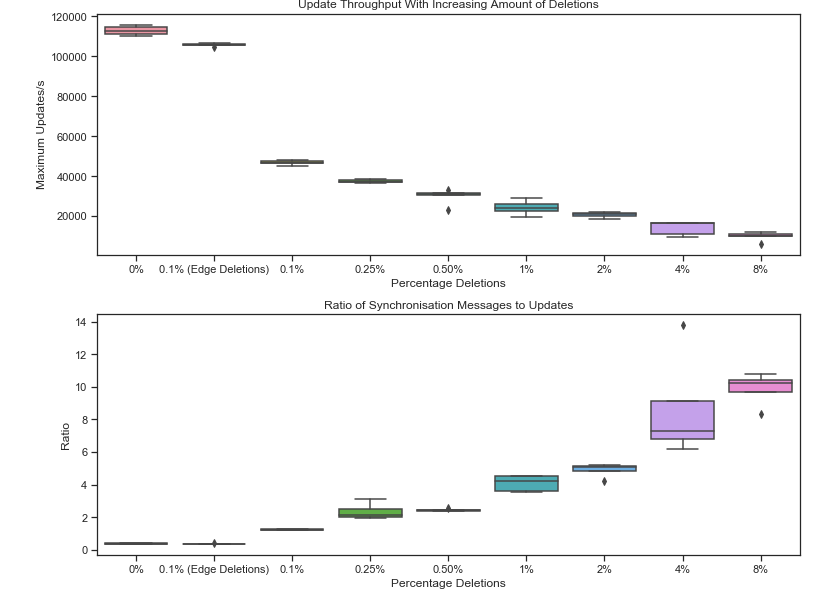

In [221]:
plt.tight_layout()
fig = plt.figure(constrained_layout=True,figsize=[14.7, 13])
spec= gridspec.GridSpec(ncols=3, nrows=2, figure=fig,width_ratios=[0.1,2.8,0.1])


ax1 = fig.add_subplot(spec[0, 1])
plt.setp([ax1], title='Update Throughput With Increasing Amount of Deletions')
ax2 = fig.add_subplot(spec[1, 1],sharex=ax1)
plt.setp([ax2], title='Ratio of Synchronisation Messages to Updates')
#ax1.get_xaxis().set_visible(False)

def getMax(pm):
    pm = pm[0].groupby('time').sum()
    return max(list(numpy.diff(list(map((lambda x: int(x)/60),list(pm['Raphtory_Router_Updates_total']))))))

def buildList(label,pm1,pm2,pm3,pm4,pm5):
    return [[label,'Writer Input',getMax(pm1)],[label,'Writer Input',getMax(pm2)],
     [label,'Writer Input',getMax(pm3)],[label,'Writer Input',getMax(pm4)],
     [label,'Writer Input',getMax(pm5)]]

pm1=buildList('0%',readRaphtoryRun("Delete_base_1"),readRaphtoryRun("Delete_base_2"),readRaphtoryRun("Delete_base_3"),readRaphtoryRun("Delete_base_4"),readRaphtoryRun("Delete_base_5"))
pme=buildList('0.1% (Edge Deletions)',readRaphtoryRun("Delete_edge_percent_1"),readRaphtoryRun("Delete_edge_percent_2"),readRaphtoryRun("Delete_edge_percent_3"),readRaphtoryRun("Delete_edge_percent_4"),readRaphtoryRun("Delete_edge_percent_5"))
pm2=buildList('0.1%',readRaphtoryRun("Delete_0.1percent_1"),readRaphtoryRun("Delete_0.1percent_2"),readRaphtoryRun("Delete_0.1percent_3"),readRaphtoryRun("Delete_0.1percent_4"),readRaphtoryRun("Delete_0.1percent_5"))
pm3=buildList('0.25%',readRaphtoryRun("Delete_0.25percent_1"),readRaphtoryRun("Delete_0.25percent_2"),readRaphtoryRun("Delete_0.25percent_3"),readRaphtoryRun("Delete_0.25percent_4"),readRaphtoryRun("Delete_0.25percent_5"))
pm4=buildList('0.50%',readRaphtoryRun("Delete_0.5percent_1"),readRaphtoryRun("Delete_0.5percent_2"),readRaphtoryRun("Delete_0.5percent_3"),readRaphtoryRun("Delete_0.5percent_4"),readRaphtoryRun("Delete_0.5percent_5"))
pm5=buildList('1%',readRaphtoryRun("Delete_1percent_1"),readRaphtoryRun("Delete_1percent_2"),readRaphtoryRun("Delete_1percent_3"),readRaphtoryRun("Delete_1percent_4"),readRaphtoryRun("Delete_1percent_5"))
pm6=buildList('2%',readRaphtoryRun("Delete_2percent_1"),readRaphtoryRun("Delete_2percent_2"),readRaphtoryRun("Delete_2percent_3"),readRaphtoryRun("Delete_2percent_4"),readRaphtoryRun("Delete_2percent_5"))
pm7=buildList('4%',readRaphtoryRun("Delete_4percent_1"),readRaphtoryRun("Delete_4percent_2"),readRaphtoryRun("Delete_4percent_3"),readRaphtoryRun("Delete_4percent_4"),readRaphtoryRun("Delete_4percent_5"))
pm8=buildList('8%',readRaphtoryRun("Delete_8percent_1"),readRaphtoryRun("Delete_8percent_2"),readRaphtoryRun("Delete_8percent_3"),readRaphtoryRun("Delete_8percent_4"),readRaphtoryRun("Delete_8percent_5"))


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11.7, 8.27)
df = pd.DataFrame(pm1+pme+pm2+pm3+pm4+pm5+pm6+pm7+pm8, columns =['Percentage Deletions', 'Type', 'Maximum Updates/s'], dtype = float) 
sns.boxplot(x='Percentage Deletions', y='Maximum Updates/s',data=df,ax=ax1)


def getMax(pm):
    pm = pm[0].groupby('time').sum()
    totalSync= [sum(x) for x in zip(list(pm['Raphtory_Inter_Worker_Updates_total']), list(pm['Raphtory_Intra_Worker_Updates_total']))]
    div = numpy.divide(totalSync,list(pm['Raphtory_Router_Updates_total']))
    return max(div)

def buildList(label,pm1,pm2,pm3,pm4,pm5):
    return [[label,'Writer Input',getMax(pm1)],[label,'Writer Input',getMax(pm2)],
     [label,'Writer Input',getMax(pm3)],[label,'Writer Input',getMax(pm4)],
     [label,'Writer Input',getMax(pm5)]]

pm1=buildList('0%',readRaphtoryRun("Delete_base_1"),readRaphtoryRun("Delete_base_2"),readRaphtoryRun("Delete_base_3"),readRaphtoryRun("Delete_base_4"),readRaphtoryRun("Delete_base_5"))
pme=buildList('0.1% (Edge Deletions)',readRaphtoryRun("Delete_edge_percent_1"),readRaphtoryRun("Delete_edge_percent_2"),readRaphtoryRun("Delete_edge_percent_3"),readRaphtoryRun("Delete_edge_percent_4"),readRaphtoryRun("Delete_edge_percent_5"))
pm2=buildList('0.1%',readRaphtoryRun("Delete_0.1percent_1"),readRaphtoryRun("Delete_0.1percent_2"),readRaphtoryRun("Delete_0.1percent_3"),readRaphtoryRun("Delete_0.1percent_4"),readRaphtoryRun("Delete_0.1percent_5"))
pm3=buildList('0.25%',readRaphtoryRun("Delete_0.25percent_1"),readRaphtoryRun("Delete_0.25percent_2"),readRaphtoryRun("Delete_0.25percent_3"),readRaphtoryRun("Delete_0.25percent_4"),readRaphtoryRun("Delete_0.25percent_5"))
pm4=buildList('0.50%',readRaphtoryRun("Delete_0.5percent_1"),readRaphtoryRun("Delete_0.5percent_2"),readRaphtoryRun("Delete_0.5percent_3"),readRaphtoryRun("Delete_0.5percent_4"),readRaphtoryRun("Delete_0.5percent_5"))
pm5=buildList('1%',readRaphtoryRun("Delete_1percent_1"),readRaphtoryRun("Delete_1percent_2"),readRaphtoryRun("Delete_1percent_3"),readRaphtoryRun("Delete_1percent_4"),readRaphtoryRun("Delete_1percent_5"))
pm6=buildList('2%',readRaphtoryRun("Delete_2percent_1"),readRaphtoryRun("Delete_2percent_2"),readRaphtoryRun("Delete_2percent_3"),readRaphtoryRun("Delete_2percent_4"),readRaphtoryRun("Delete_2percent_5"))
pm7=buildList('4%',readRaphtoryRun("Delete_4percent_1"),readRaphtoryRun("Delete_4percent_2"),readRaphtoryRun("Delete_4percent_3"),readRaphtoryRun("Delete_4percent_4"),readRaphtoryRun("Delete_4percent_5"))
pm8=buildList('8%',readRaphtoryRun("Delete_8percent_1"),readRaphtoryRun("Delete_8percent_2"),readRaphtoryRun("Delete_8percent_3"),readRaphtoryRun("Delete_8percent_4"),readRaphtoryRun("Delete_8percent_5"))


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11.7, 8.27)
df = pd.DataFrame(pm1+pme+pm2+pm3+pm4+pm5+pm6+pm7+pm8, columns =['Percentage Deletions', 'Type', 'Ratio'], dtype = float) 
ax = sns.boxplot(x='Percentage Deletions', y='Ratio',data=df)
plt.savefig('Deletions.pdf',bbox_inches='tight')
plt.show()

141.362864
128.982459
137.508867
139.746932
136.580788
214.051377
218.629775
216.122634
213.173034
210.629212
347.226606
103.382682
371.598169
353.297061
367.275986
806.287028
798.342986
716.902947
805.700312
802.043511
1541.837284
1563.013485
1563.013485
1563.013485
1563.013485
13.599381
11.842988
13.008802
13.342142
12.885015
23.707624
24.246042
23.946315
23.600305
23.280187
45.192649
8.457717
50.274263
46.409356
49.316966
115.735428
114.837123
103.624947
115.660411
115.248501
204.31635
206.899919
206.899919
206.899919
206.899919


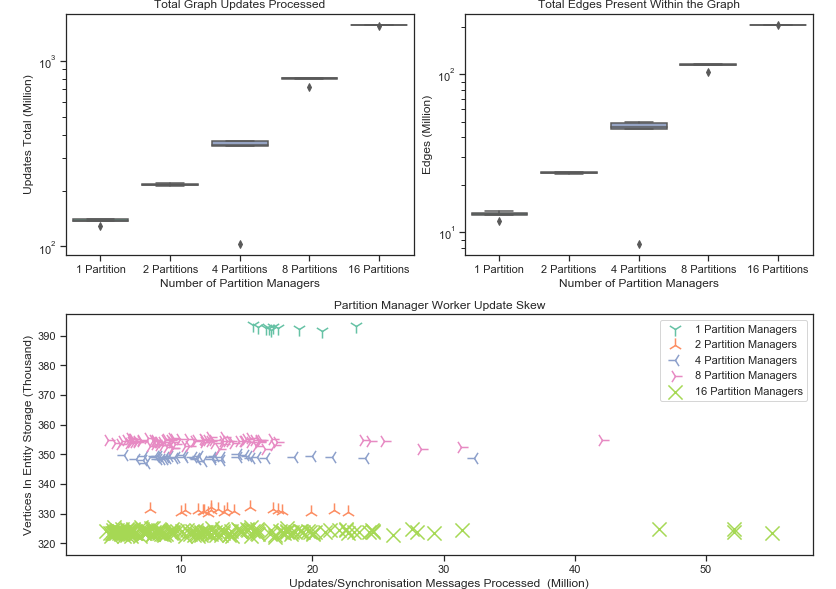

In [237]:

fig = plt.figure(constrained_layout=True,figsize=[11.7, 8.27])
spec= gridspec.GridSpec(ncols=6, nrows=2, figure=fig,width_ratios=[0.1,0.7,0.7,0.7,0.7,0.1])

ax1 = fig.add_subplot(spec[0, 1:3])
plt.yscale("log")
ax2 = fig.add_subplot(spec[0, 3:5])
plt.yscale("log")
ax3 = fig.add_subplot(spec[1, 1:5])
plt.setp([ax1], title='Total Graph Updates Processed')
plt.setp([ax2], title='Total Edges Present Within the Graph')


# def getMax(pm):
#     pm = pm[0].groupby('time').sum()
#     return (max(list(pm['Raphtory_Router_Updates_total']))/2131901271)*100

# pm1=buildList('1 ',readRaphtoryRun("scale_out_1_1"),readRaphtoryRun("scale_out_1_2"),readRaphtoryRun("scale_out_1_3"),readRaphtoryRun("scale_out_1_4"),readRaphtoryRun("scale_out_1_5"))
# pm2=buildList('2 ',readRaphtoryRun("scale_out_2_1"),readRaphtoryRun("scale_out_2_2"),readRaphtoryRun("scale_out_2_3"),readRaphtoryRun("scale_out_2_4"),readRaphtoryRun("scale_out_2_5"))
# pm3=buildList('4 ',readRaphtoryRun("scale_out_4_1"),readRaphtoryRun("scale_out_4_2"),readRaphtoryRun("scale_out_4_3"),readRaphtoryRun("scale_out_4_4"),readRaphtoryRun("scale_out_4_5"))
# pm4=buildList('8 ',readRaphtoryRun("scale_out_8_1"),readRaphtoryRun("scale_out_8_2"),readRaphtoryRun("scale_out_8_3"),readRaphtoryRun("scale_out_8_4"),readRaphtoryRun("scale_out_8_5"))
# pm5=buildList('16 ',readRaphtoryRun("scale_out_16_1"),readRaphtoryRun("scale_out_16_2"),readRaphtoryRun("scale_out_16_2"),readRaphtoryRun("scale_out_16_2"),readRaphtoryRun("scale_out_16_2"))#,readRaphtoryRun("scale_out_16_3"),readRaphtoryRun("scale_out_16_4"),readRaphtoryRun("scale_out_16_5"))


# df = pd.DataFrame(pm1+pm2+pm3+pm4+pm5, columns =['Number of Partition Managers', 'Type', 'Percentage of Ethereum Transactions'], dtype = float) 
# sns.boxplot(x='Number of Partition Managers', y='Percentage of Ethereum Transactions',data=df,ax=ax1)

def getMax(pm):
    pm = pm[0].groupby('time').sum()
    print(max(list(pm['Raphtory_Router_Updates_total']))/1000000)
    return max(list(pm['Raphtory_Router_Updates_total']))/1000000

pm1=buildList('1 Partition',readRaphtoryRun("scale_out_1_1"),readRaphtoryRun("scale_out_1_2"),readRaphtoryRun("scale_out_1_3"),readRaphtoryRun("scale_out_1_4"),readRaphtoryRun("scale_out_1_5"))
pm2=buildList('2 Partitions',readRaphtoryRun("scale_out_2_1"),readRaphtoryRun("scale_out_2_2"),readRaphtoryRun("scale_out_2_3"),readRaphtoryRun("scale_out_2_4"),readRaphtoryRun("scale_out_2_5"))
pm3=buildList('4 Partitions',readRaphtoryRun("scale_out_4_1"),readRaphtoryRun("scale_out_4_2"),readRaphtoryRun("scale_out_4_3"),readRaphtoryRun("scale_out_4_4"),readRaphtoryRun("scale_out_4_5"))
pm4=buildList('8 Partitions',readRaphtoryRun("scale_out_8_1"),readRaphtoryRun("scale_out_8_2"),readRaphtoryRun("scale_out_8_3"),readRaphtoryRun("scale_out_8_4"),readRaphtoryRun("scale_out_8_5"))
pm5=buildList('16 Partitions',readRaphtoryRun("scale_out_16_1"),readRaphtoryRun("scale_out_16_2"),readRaphtoryRun("scale_out_16_2"),readRaphtoryRun("scale_out_16_2"),readRaphtoryRun("scale_out_16_2"))#,readRaphtoryRun("scale_out_16_3"),readRaphtoryRun("scale_out_16_4"),readRaphtoryRun("scale_out_16_5"))

df = pd.DataFrame(pm1+pm2+pm3+pm4+pm5, columns =['Number of Partition Managers', 'Type', 'Updates Total (Million)'], dtype = float) 
sns.boxplot(x='Number of Partition Managers', y='Updates Total (Million)',data=df,ax=ax1)




# def getMax(pm):
#     pm = pm[0].groupby('time').sum()
#     return max(list(pm['Raphtory_Vertex_Count_total']))/1000000

# pm1=buildList('1',readRaphtoryRun("scale_out_1_1"),readRaphtoryRun("scale_out_1_2"),readRaphtoryRun("scale_out_1_3"),readRaphtoryRun("scale_out_1_4"),readRaphtoryRun("scale_out_1_5"))
# pm2=buildList('2',readRaphtoryRun("scale_out_2_1"),readRaphtoryRun("scale_out_2_2"),readRaphtoryRun("scale_out_2_3"),readRaphtoryRun("scale_out_2_4"),readRaphtoryRun("scale_out_2_5"))
# pm3=buildList('4',readRaphtoryRun("scale_out_4_1"),readRaphtoryRun("scale_out_4_2"),readRaphtoryRun("scale_out_4_3"),readRaphtoryRun("scale_out_4_4"),readRaphtoryRun("scale_out_4_5"))
# pm4=buildList('8',readRaphtoryRun("scale_out_8_1"),readRaphtoryRun("scale_out_8_2"),readRaphtoryRun("scale_out_8_3"),readRaphtoryRun("scale_out_8_4"),readRaphtoryRun("scale_out_8_5"))
# pm5=buildList('16',readRaphtoryRun("scale_out_16_1"),readRaphtoryRun("scale_out_16_2"),readRaphtoryRun("scale_out_16_2"),readRaphtoryRun("scale_out_16_2"),readRaphtoryRun("scale_out_16_2"))#,readRaphtoryRun("scale_out_16_3"),readRaphtoryRun("scale_out_16_4"),readRaphtoryRun("scale_out_16_5"))


# df = pd.DataFrame(pm1+pm2+pm3+pm4+pm5, columns =['Number of Partition Managers', 'Type', 'Vertices (Million)'], dtype = float) 
# sns.boxplot(x='Number of Partition Managers', y='Vertices (Million)',data=df,ax=ax3)


def getMax(pm):
    pm = pm[0].groupby('time').sum()
    print(max([sum(x) for x in zip(list(pm['Raphtory_Master_Split_Edge_Count_total']), list(pm['Raphtory_Local_Edge_Count_total']))])/1000000)
    return max([sum(x) for x in zip(list(pm['Raphtory_Master_Split_Edge_Count_total']), list(pm['Raphtory_Local_Edge_Count_total']))])/1000000

pm1=buildList('1 Partition',readRaphtoryRun("scale_out_1_1"),readRaphtoryRun("scale_out_1_2"),readRaphtoryRun("scale_out_1_3"),readRaphtoryRun("scale_out_1_4"),readRaphtoryRun("scale_out_1_5"))
pm2=buildList('2 Partitions',readRaphtoryRun("scale_out_2_1"),readRaphtoryRun("scale_out_2_2"),readRaphtoryRun("scale_out_2_3"),readRaphtoryRun("scale_out_2_4"),readRaphtoryRun("scale_out_2_5"))
pm3=buildList('4 Partitions',readRaphtoryRun("scale_out_4_1"),readRaphtoryRun("scale_out_4_2"),readRaphtoryRun("scale_out_4_3"),readRaphtoryRun("scale_out_4_4"),readRaphtoryRun("scale_out_4_5"))
pm4=buildList('8 Partitions',readRaphtoryRun("scale_out_8_1"),readRaphtoryRun("scale_out_8_2"),readRaphtoryRun("scale_out_8_3"),readRaphtoryRun("scale_out_8_4"),readRaphtoryRun("scale_out_8_5"))
pm5=buildList('16 Partitions',readRaphtoryRun("scale_out_16_1"),readRaphtoryRun("scale_out_16_2"),readRaphtoryRun("scale_out_16_2"),readRaphtoryRun("scale_out_16_2"),readRaphtoryRun("scale_out_16_2"))#,readRaphtoryRun("scale_out_16_3"),readRaphtoryRun("scale_out_16_4"),readRaphtoryRun("scale_out_16_5"))


df = pd.DataFrame(pm1+pm2+pm3+pm4+pm5, columns =['Number of Partition Managers', 'Type', 'Edges (Million)'], dtype = float) 
sns.boxplot(x='Number of Partition Managers', y='Edges (Million)',data=df,ax=ax2)


def getData(pm):
    pmMax         = pm.groupby(['metric.actor','metric.ID']).max().reset_index()   
    pmUpdates     = list(pmMax['Raphtory_Router_Updates_total'])
    pmIntra       = list(pmMax['Raphtory_Intra_Worker_Updates_total'])
    pmInter       = list(pmMax['Raphtory_Inter_Worker_Updates_total'])
    pmFUpdate     = list(map((lambda x: int(x)/1000000),[sum(x) for x in zip(pmUpdates, [sum(x) for x in zip(pmInter, pmIntra)])]))
    pmVertex      = list(map((lambda x: int(x)/1000),list(pmMax['Raphtory_Vertex_Count_total'])))
    return [pmFUpdate,pmVertex]

def distributionPlot(pm1,pm2,pm4,pm8,pm16,ax):
    
    #fig           = plt.figure(constrained_layout=True,figsize=[14.7, 5])
    #spec          = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

   # ax1 = fig.add_subplot(spec[0:3, 0])
    pm1Updates = getData(pm1) 
    pm2Updates  = getData(pm2) 
    pm4Updates = getData(pm4) 
    pm16Updates = getData(pm16) 
    pm8Updates  = getData(pm8) 
    
    #UPDATE THROUGHPUT
    plt.setp([ax], title='Partition Manager Worker Update Skew')
    plt.setp([ax], xlabel='Updates/Synchronisation Messages Processed  (Million)')
    plt.setp([ax], ylabel='Vertices In Entity Storage (Thousand)')
    
    ax.scatter(pm1Updates[0],pm1Updates[1],label="1 Partition Managers",marker="1",s=200)
    ax.scatter(pm2Updates[0],pm2Updates[1],label="2 Partition Managers",marker="2",s=200)
    ax.scatter(pm4Updates[0],pm4Updates[1],label="4 Partition Managers",marker="3",s=200)
    ax.scatter(pm8Updates[0],pm8Updates[1],label="8 Partition Managers",marker="4",s=200)
    ax.scatter(pm16Updates[0],pm16Updates[1],label="16 Partition Managers",marker="x",s=200)
    
    

    #ax1.plot(range(0,len(pmInter)),pmInter,label="Partition Manager Inter Writer Synchronisation")
    ax.legend(loc="best")
    
distributionPlot(readRaphtoryRun("scale_out_1_3")[0],readRaphtoryRun("scale_out_2_3")[0],
                 readRaphtoryRun("scale_out_4_3")[0],readRaphtoryRun("scale_out_8_3")[0],
                 readRaphtoryRun("scale_out_16_2")[0],ax3)
plt.savefig('scaleout.pdf',bbox_inches='tight')


#2131901271

In [1]:
# exportRaphtoryRun("2020-09-01T10:50:07","2020-09-01T10:58:07","ScaleUp_m5a.large_1")
# exportRaphtoryRun("2020-09-01T11:19:07","2020-09-01T11:27:07","ScaleUp_m5a.large_2")
# exportRaphtoryRun("2020-09-01T12:21:07","2020-09-01T12:29:07","ScaleUp_m5a.large_3")
# exportRaphtoryRun("2020-09-01T12:51:07","2020-09-01T12:59:07","ScaleUp_m5a.large_4")
# exportRaphtoryRun("2020-09-01T14:09:07","2020-09-01T14:17:07","ScaleUp_m5a.large_5")

# exportRaphtoryRun("2020-09-02T00:00:07","2020-09-02T00:06:07","ScaleUp_m5a.xlarge_1")
# exportRaphtoryRun("2020-09-02T00:09:07","2020-09-02T00:15:07","ScaleUp_m5a.xlarge_2")
# exportRaphtoryRun("2020-09-02T00:17:07","2020-09-02T00:24:07","ScaleUp_m5a.xlarge_3")
# exportRaphtoryRun("2020-09-02T00:27:07","2020-09-02T00:34:07","ScaleUp_m5a.xlarge_4")
# exportRaphtoryRun("2020-09-02T00:41:07","2020-09-02T00:48:07","ScaleUp_m5a.xlarge_5")

# exportRaphtoryRun("2020-09-01T22:54:07","2020-09-01T23:02:07","ScaleUp_m5a.2xlarge_1")
# exportRaphtoryRun("2020-09-01T23:08:07","2020-09-01T23:15:07","ScaleUp_m5a.2xlarge_2")
# exportRaphtoryRun("2020-09-01T23:20:07","2020-09-01T23:27:07","ScaleUp_m5a.2xlarge_3")
# exportRaphtoryRun("2020-09-01T23:33:07","2020-09-01T23:40:07","ScaleUp_m5a.2xlarge_4")
# exportRaphtoryRun("2020-09-01T23:45:07","2020-09-01T23:51:07","ScaleUp_m5a.2xlarge_5")

# exportRaphtoryRun("2020-09-01T20:04:07","2020-09-01T20:14:07","ScaleUp_m5a.4xlarge_1")
# exportRaphtoryRun("2020-09-01T21:52:07","2020-09-01T22:04:07","ScaleUp_m5a.4xlarge_2")
# exportRaphtoryRun("2020-09-01T22:10:07","2020-09-01T22:20:07","ScaleUp_m5a.4xlarge_3")
# exportRaphtoryRun("2020-09-01T22:24:07","2020-09-01T22:33:07","ScaleUp_m5a.4xlarge_4")
# exportRaphtoryRun("2020-09-01T22:39:07","2020-09-01T22:51:07","ScaleUp_m5a.4xlarge_5")

# exportRaphtoryRun("2020-09-01T20:19:07","2020-09-01T20:34:07","ScaleUp_m5a.8xlarge_1")
# exportRaphtoryRun("2020-09-01T20:38:07","2020-09-01T20:50:07","ScaleUp_m5a.8xlarge_2")
# exportRaphtoryRun("2020-09-01T21:11:07","2020-09-01T21:22:07","ScaleUp_m5a.8xlarge_3")
# exportRaphtoryRun("2020-09-01T21:24:07","2020-09-01T21:34:07","ScaleUp_m5a.8xlarge_4")
# exportRaphtoryRun("2020-09-01T21:36:07","2020-09-01T21:48:07","ScaleUp_m5a.8xlarge_5")

# exportRaphtoryRun("2020-09-01T17:48:07","2020-09-01T18:04:07","ScaleUp_m5a.16xlarge_1")
# exportRaphtoryRun("2020-09-01T17:29:07","2020-09-01T17:44:07","ScaleUp_m5a.16xlarge_2")
# exportRaphtoryRun("2020-09-01T17:13:07","2020-09-01T17:26:07","ScaleUp_m5a.16xlarge_3")
# exportRaphtoryRun("2020-09-01T16:39:07","2020-09-01T16:55:07","ScaleUp_m5a.16xlarge_4")
# exportRaphtoryRun("2020-09-01T16:21:07","2020-09-01T16:34:07","ScaleUp_m5a.16xlarge_5")

In [2]:
#exportRaphtoryRun("2020-08-31T20:17:00","2020-08-31T21:02:00","InitialRun4Router")

#exportRaphtoryRun("2020-09-01T14:31:00","2020-09-01T15:45:00","InitialRun1Router")

In [194]:
#exportRaphtoryRun("2020-09-05T01:28:07","2020-09-05T01:54:07","Delete_base_1")
#exportRaphtoryRun("2020-09-05T01:58:07","2020-09-05T02:23:07","Delete_base_2")
#exportRaphtoryRun("2020-09-05T02:29:07","2020-09-05T02:54:07","Delete_base_3")
#exportRaphtoryRun("2020-09-05T03:00:07","2020-09-05T03:25:07","Delete_base_4")
#exportRaphtoryRun("2020-09-05T03:30:07","2020-09-05T03:55:07","Delete_base_5")

#exportRaphtoryRun("2020-09-08T14:20:07","2020-09-08T14:58:07","Delete_edge_percent_1")
#exportRaphtoryRun("2020-09-08T15:26:07","2020-09-08T16:05:07","Delete_edge_percent_2")
#exportRaphtoryRun("2020-09-08T16:06:07","2020-09-08T16:44:07","Delete_edge_percent_3")
#exportRaphtoryRun("2020-09-08T16:45:07","2020-09-08T17:19:07","Delete_edge_percent_4")
#exportRaphtoryRun("2020-09-08T17:21:07","2020-09-08T18:01:07","Delete_edge_percent_5")

# exportRaphtoryRun("2020-09-05T19:20:07","2020-09-05T19:34:07","Delete_0.1percent_1")
# exportRaphtoryRun("2020-09-05T19:38:07","2020-09-05T19:51:07","Delete_0.1percent_2")
# exportRaphtoryRun("2020-09-05T19:55:07","2020-09-05T20:08:07","Delete_0.1percent_3")
# exportRaphtoryRun("2020-09-05T20:13:07","2020-09-05T20:26:07","Delete_0.1percent_4")
# exportRaphtoryRun("2020-09-05T20:30:07","2020-09-05T20:42:07","Delete_0.1percent_5")

# exportRaphtoryRun("2020-09-05T20:47:07","2020-09-05T20:58:07","Delete_0.25percent_1")
# exportRaphtoryRun("2020-09-05T21:04:07","2020-09-05T21:15:07","Delete_0.25percent_2")
# exportRaphtoryRun("2020-09-05T21:21:07","2020-09-05T21:31:07","Delete_0.25percent_3")
# exportRaphtoryRun("2020-09-05T21:38:07","2020-09-05T21:49:07","Delete_0.25percent_4")
# exportRaphtoryRun("2020-09-05T21:55:07","2020-09-05T22:06:07","Delete_0.25percent_5")

# exportRaphtoryRun("2020-09-05T22:13:07","2020-09-05T22:22:07","Delete_0.5percent_1")
# exportRaphtoryRun("2020-09-05T22:30:07","2020-09-05T22:38:07","Delete_0.5percent_2")
# exportRaphtoryRun("2020-09-05T22:46:07","2020-09-05T22:56:07","Delete_0.5percent_3")
# exportRaphtoryRun("2020-09-05T23:03:07","2020-09-05T23:14:07","Delete_0.5percent_4")
# exportRaphtoryRun("2020-09-05T23:21:07","2020-09-05T23:30:07","Delete_0.5percent_5")

# exportRaphtoryRun("2020-09-05T13:22:07","2020-09-05T13:28:07","Delete_1percent_1")
# exportRaphtoryRun("2020-09-05T13:44:07","2020-09-05T13:52:07","Delete_1percent_2")
# exportRaphtoryRun("2020-09-05T14:15:07","2020-09-05T14:22:07","Delete_1percent_3")
# exportRaphtoryRun("2020-09-05T14:32:07","2020-09-05T14:42:07","Delete_1percent_4")
# exportRaphtoryRun("2020-09-05T14:51:07","2020-09-05T14:58:07","Delete_1percent_5")

# exportRaphtoryRun("2020-09-05T15:09:07","2020-09-05T15:15:07","Delete_2percent_1")
# exportRaphtoryRun("2020-09-05T15:26:07","2020-09-05T15:32:07","Delete_2percent_2")
# exportRaphtoryRun("2020-09-05T15:43:07","2020-09-05T15:50:07","Delete_2percent_3")
# exportRaphtoryRun("2020-09-05T16:00:07","2020-09-05T16:06:07","Delete_2percent_4")
# exportRaphtoryRun("2020-09-05T16:15:07","2020-09-05T16:21:07","Delete_2percent_5")

#exportRaphtoryRun("2020-09-05T16:29:07","2020-09-05T16:35:07","Delete_4percent_1")
#exportRaphtoryRun("2020-09-05T16:47:07","2020-09-05T16:52:07","Delete_4percent_2")
#exportRaphtoryRun("2020-09-05T17:03:07","2020-09-05T17:10:07","Delete_4percent_3")
#exportRaphtoryRun("2020-09-05T17:20:07","2020-09-05T17:27:07","Delete_4percent_4")
#exportRaphtoryRun("2020-09-05T17:38:07","2020-09-05T17:44:07","Delete_4percent_5")

#exportRaphtoryRun("2020-09-05T17:54:07","2020-09-05T18:01:07","Delete_8percent_1")
#exportRaphtoryRun("2020-09-05T18:13:07","2020-09-05T18:17:07","Delete_8percent_2")
#exportRaphtoryRun("2020-09-05T18:29:07","2020-09-05T18:34:07","Delete_8percent_3")
#exportRaphtoryRun("2020-09-05T18:46:07","2020-09-05T18:52:07","Delete_8percent_4")
#exportRaphtoryRun("2020-09-05T19:04:07","2020-09-05T19:08:07","Delete_8percent_5")

In [109]:
#exportRaphtoryRun("2020-09-06T22:02:07","2020-09-06T23:05:30","scale_out_1_1")
#exportRaphtoryRun("2020-09-06T23:07:07","2020-09-07T00:06:00","scale_out_1_2")
#exportRaphtoryRun("2020-09-07T00:07:00","2020-09-07T01:10:00","scale_out_1_3")
#exportRaphtoryRun("2020-09-07T01:11:00","2020-09-07T02:15:00","scale_out_1_4")
#exportRaphtoryRun("2020-09-07T02:17:00","2020-09-07T03:20:00","scale_out_1_5")

#exportRaphtoryRun("2020-09-07T03:21:00","2020-09-07T04:27:00","scale_out_2_1")
#exportRaphtoryRun("2020-09-07T04:28:00","2020-09-07T05:34:00","scale_out_2_2")
#exportRaphtoryRun("2020-09-07T05:35:00","2020-09-07T06:41:00","scale_out_2_3")
#exportRaphtoryRun("2020-09-07T06:42:00","2020-09-07T07:47:00","scale_out_2_4")
#exportRaphtoryRun("2020-09-07T07:49:00","2020-09-07T08:53:00","scale_out_2_5")

# exportRaphtoryRun("2020-09-07T08:55:00","2020-09-07T10:15:00","scale_out_4_1")
# exportRaphtoryRun("2020-09-07T10:17:00","2020-09-07T10:40:00","scale_out_4_2")
# exportRaphtoryRun("2020-09-07T11:42:00","2020-09-07T13:07:00","scale_out_4_3")
# exportRaphtoryRun("2020-09-07T13:09:00","2020-09-07T14:28:00","scale_out_4_4")
# exportRaphtoryRun("2020-09-07T14:31:00","2020-09-07T15:53:00","scale_out_4_5")

#exportRaphtoryRun("2020-09-07T15:56:00","2020-09-07T18:20:00","scale_out_8_1")
#exportRaphtoryRun("2020-09-07T18:22:00","2020-09-07T20:46:00","scale_out_8_2")
#exportRaphtoryRun("2020-09-07T20:47:00","2020-09-07T22:57:00","scale_out_8_3")
#exportRaphtoryRun("2020-09-07T22:58:00","2020-09-08T01:24:00","scale_out_8_4")
#exportRaphtoryRun("2020-09-08T01:27:00","2020-09-08T03:50:00","scale_out_8_5")

#exportRaphtoryRun("2020-09-08T03:52:00","2020-09-08T08:26:00","scale_out_16_1")
#exportRaphtoryRun("2020-09-08T08:31:00","2020-09-08T13:07:00","scale_out_16_2")